In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde, linregress
import pickle as pkl
from utils import u_plot as uplot, u_darrays as uda, u_met
import pandas as pd

##for regridding, install xesmf:
# conda install esmpy\\
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (30., 30.)
#%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [10]:
era_march = pkl.load( open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_march.p', 'rb'))
era_oct = pkl.load( open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_oct.p', 'rb'))
era_all = pkl.load(open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_allmonth_5-8N_2000-2014_18UTC_front.p', 'rb'))
#era_all = pkl.load(open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_allmonth_2000-2014.p', 'rb'))

In [11]:
era_all.keys()

dict_keys(['lat', 'u925_s', 'q_col', 'slp_s', 'slp', 't10', 'v_col', 'dates', 'u_col_s', 'tmean', 'r_col', 'r_col_s', 'u650_s', 'u925', 'CAPE_s', 'tcwv', 'd925_s', 'CAPE', 'u_col', 'd_col_s', 't2', 'd_col', 'divMoist_s', 't_col', 'divMoist', 't2_s', 'tcwv_s', 't_col_s', 'lon', 'level', 'q_col_s', 'q925', 'tmin', 'v_col_s', 'q700', 'q925_s', 'area', 'area70', 'q700_s', 'u650', 'd925'])

In [12]:
def get_col(var):
    vdic = {}
    vdic['low'] = []
    vdic['high'] = []
    vdic['mean'] = []
    for v in var:
        
        vdic['low'].append(v[16])
        vdic['high'].append(v[9])
        vdic['mean'].append(np.array(v).mean())        
    return vdic

In [13]:
def get_q(var):
    vdic = {}
    vdic['low'] = []
    for v in var:
        
        vdic['low'].append(np.array(v[13:17]).mean())   #10:19 is 750 to 925
     
    return vdic

In [14]:
np.median(era_all['q_col'])

0.0057981336

In [15]:
np.median(era_all['q925'])

0.015498809982091188

In [16]:
era_all.keys()

dict_keys(['lat', 'u925_s', 'q_col', 'slp_s', 'slp', 't10', 'v_col', 'dates', 'u_col_s', 'tmean', 'r_col', 'r_col_s', 'u650_s', 'u925', 'CAPE_s', 'tcwv', 'd925_s', 'CAPE', 'u_col', 'd_col_s', 't2', 'd_col', 'divMoist_s', 't_col', 'divMoist', 't2_s', 'tcwv_s', 't_col_s', 'lon', 'level', 'q_col_s', 'q925', 'tmin', 'v_col_s', 'q700', 'q925_s', 'area', 'area70', 'q700_s', 'u650', 'd925'])

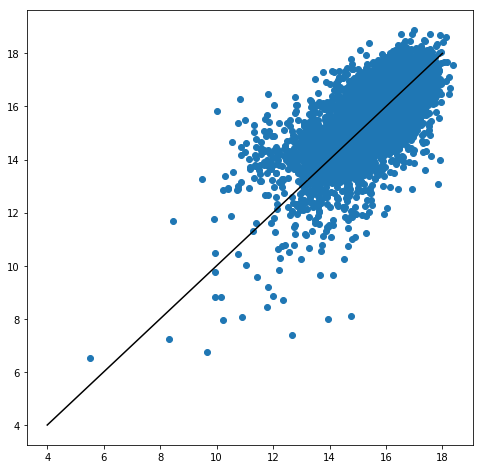

In [17]:
plt.figure(figsize=(8,8))
plt.scatter(np.array(era_all['q925_s'])*1000,np.array(era_all['q925'])*1000)
plt.plot(np.arange(4,19), np.arange(4,19), 'k')

In [18]:
diff = np.array(era_all['q925_s'])*1000-np.array(era_all['q925'])*1000
print(np.sum(diff>0))
print(np.sum(diff<0))

7423
7674


In [19]:
level = era_march.pop('level')
level = era_oct.pop('level')
level = era_all.pop('level')

In [20]:
level[13:17]

[850, 875, 900, 925]

In [21]:
for k in era_march.keys():
    era_march[k] = era_march[k][0:1841]

In [22]:
for k in era_oct.keys():
    era_oct[k] = era_oct[k][0:2096]

In [23]:
np.array(era_oct['CAPE']).mean()

1063.4757279858334

In [24]:
np.array(era_march['CAPE']).mean()

1237.0779014713798

In [25]:
era_all_qsum = get_q(era_all['q_col'])
era_all['q_col_sum'] = era_all_qsum['low']
era_all_qsum_storm = get_q(era_all['q_col_s'])
era_all['q_col_sum_s'] = era_all_qsum_storm['low']

In [26]:
era_new = era_all.copy()
octt = era_all.copy()
marchh = era_all.copy()

In [27]:
for k in era_all.keys():
    print(k)
#     if k == 'dates':
#         continue
    varlist = []
    varo = []
    varm = []
    for ids, ise in enumerate(era_all[k]):
        if (era_all['dates'][ids].month <=7) | (era_all['dates'][ids].month >=9):
            varlist.append(ise)
        if era_all['dates'][ids].month == 3:
            varm.append(ise)
        if era_all['dates'][ids].month == 10:
            varo.append(ise)
    era_new[k] = np.array(varlist)          
    octt[k] = np.array(varo)
    marchh[k] = np.array(varm)

lat
u925_s
q_col
slp_s
slp
t10
v_col
dates
u_col_s
tmean
r_col
r_col_s
u650_s
u925
CAPE_s
tcwv
d925_s
CAPE
u_col
d_col_s
t2
d_col
divMoist_s
t_col
divMoist
t2_s
tcwv_s
t_col_s
lon
q_col_sum_s
q_col_s
q925
tmin
v_col_s
q700
q925_s
area
area70
q700_s
u650
d925
q_col_sum


In [28]:
qmsort = np.argsort(marchh['q925'])
qm = marchh['q925'][qmsort]

In [29]:
qesort = np.argsort(np.array(era_march['q925']))
qe = np.array(era_march['q925'])[qesort]

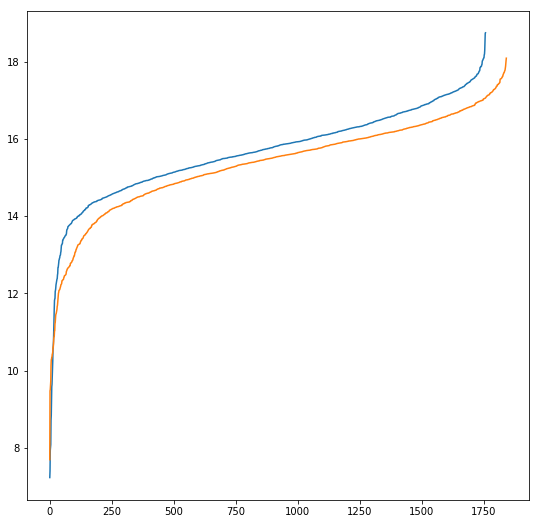

In [30]:
f=plt.figure(figsize=(9,9))
ax = f.add_subplot(111)
plt.plot(qm*1000)
plt.plot(qe*1000)

In [31]:
print(marchh['CAPE'].mean())
print(marchh['CAPE_s'].mean())

1283.6657969753837
1339.4674588131818


In [32]:
print(octt['CAPE'].mean())
print(octt['CAPE_s'].mean())

992.6763119211516
731.7759481819013


In [33]:
def sort_vars(dic):
    q925 = np.array(dic['q_col_sum'])
    q925s = np.array(dic['q_col_sum_s'])
    
    udic = get_col(dic['u_col'])
    vdic = get_col(dic['v_col'])
    
    ushear = (np.array(udic['high'])-np.array(udic['low']))
    vshear = (np.array(vdic['high'])-np.array(vdic['low']))
    shearss = u_met.u_v_to_ws_wd(ushear, vshear)
    
    shears = shearss[0]
    #shears = np.array(dic['u650']) - np.array(dic['u925']) #shearss[0]
    q925 = q925 #(q925s-
    sort = np.argsort(q925)
    q = q925[sort]*1000
    shear = shears[sort]
    tmin = np.array(dic['tmean'])[sort]
    linsp = np.linspace(0,len(q)-1,10)
    
    inds = np.round(linsp).astype(int)
    #ipdb.set_trace()
    f=plt.figure(figsize=(13,9))
    ax = f.add_subplot(311)
    plt.plot(q)
    #plt.ylim(8,18)
    ax = f.add_subplot(312)
    plt.plot(shear,'r')
    ax = f.add_subplot(313)
    plt.plot(tmin,'k')
    
    plt.show()
    
    qmean = []
    corr = []
    qcorr = []
    
    for start,end in enumerate(inds[2::]):  #
        #ipdb.set_trace()
        qmean.append(np.median(q[inds[start]:end]))
        corr.append(stats.pearsonr(shear[inds[start]:end],tmin[inds[start]:end])[0])    
        qcorr.append(stats.pearsonr(shear[inds[start]:end],q[inds[start]:end])[0])  

#         ttslope, intercept, r, p, std_err = linregress(shear[start:end],tmin[start:end])
#         ccslope, intercept, r, p, std_err = linregress(shear[start:end],q[start:end])
#         corr.append(ttslope)    
#         qcorr.append(ccslope)  
    return qmean, corr, qcorr

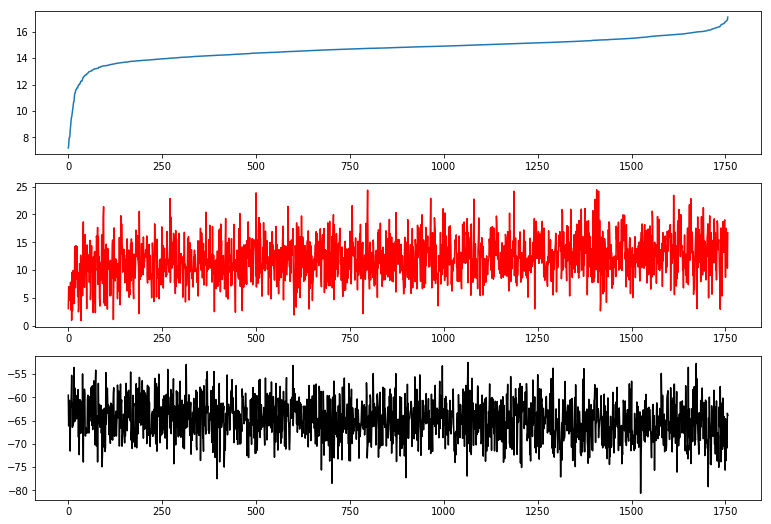

In [34]:
qmean_march, corr_march, qcorr_march = sort_vars(marchh)

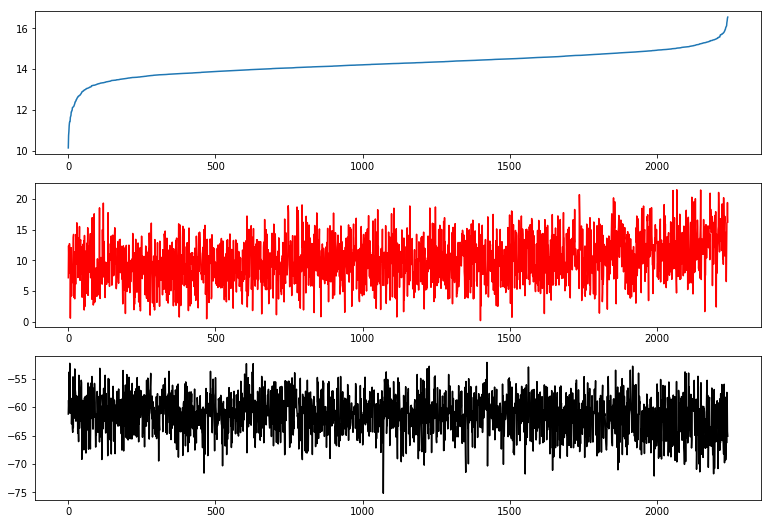

In [35]:
qmean_oct, corr_oct, qcorr_oct = sort_vars(octt)

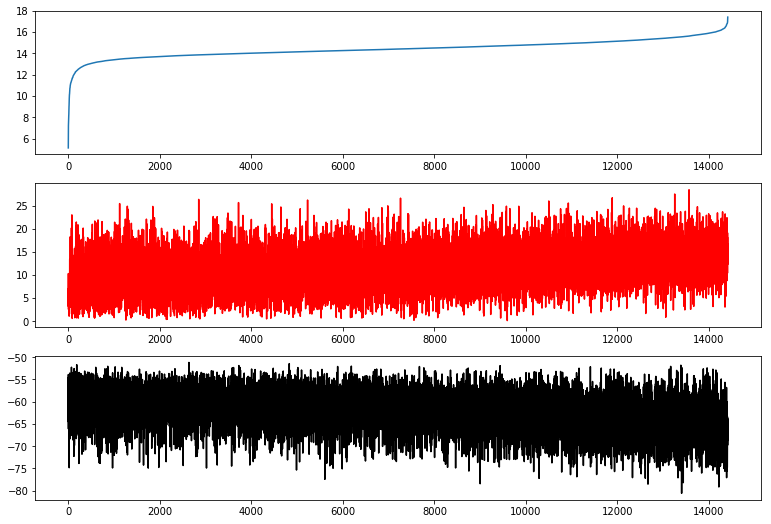

In [36]:
qmean_all, corr_all, qcorr_all = sort_vars(era_new)

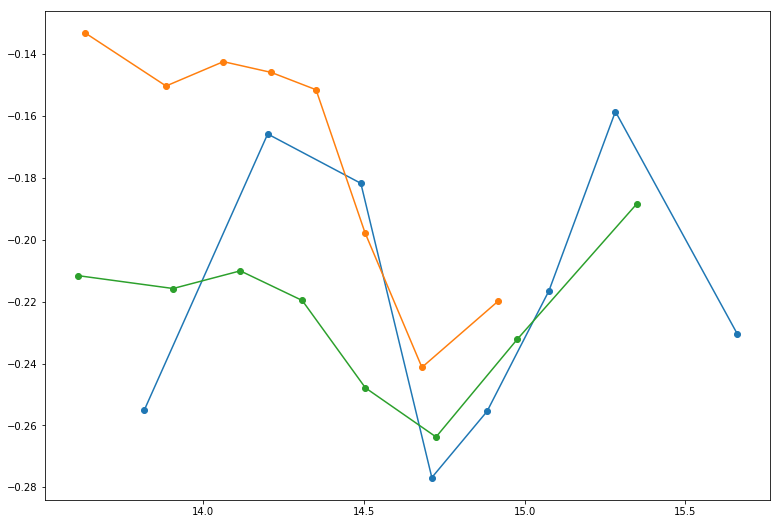

In [37]:
plt.figure(figsize=(13,9))
plt.plot(np.array(qmean_march),corr_march, '-o')
plt.plot(np.array(qmean_oct),corr_oct, '-o')
plt.plot(np.array(qmean_all),corr_all, '-o')

In [38]:
def sort_vars(dic):
    q925e = np.array(dic['q_col_sum'])
    q925s = np.array(dic['q_col_sum_s'])
    
    udic = get_col(dic['u_col'])
    vdic = get_col(dic['v_col'])
    qdic = get_col(dic['q_col'])
    qdics = get_col(dic['q_col_s'])
    
    ushear = (np.array(udic['high'])-np.array(udic['low']))
    vshear = (np.array(vdic['high'])-np.array(vdic['low']))
    shearss = u_met.u_v_to_ws_wd(ushear, vshear)
    shears = np.array(dic['u650']) - np.array(dic['u925']) #shearss[0]
    
    
    q925 = (q925s-q925e)/q925s #np.array(qdics['high'])-np.array(qdic['high'])#
    sort = np.argsort(q925e)
    q = q925[sort]
    shear = shears[sort]
    tmin = np.array(dic['tmin'])[sort]
    linsp = np.linspace(0,len(q)-1,15)
    
    inds = np.round(linsp).astype(int)
    #ipdb.set_trace()
    f=plt.figure(figsize=(13,9))
    ax = f.add_subplot(311)
    plt.plot(q)
    #plt.ylim(8,18)
    ax = f.add_subplot(312)
    plt.plot(shear,'r')
    ax = f.add_subplot(313)
    plt.plot(tmin,'k')
    
    plt.show()
    
    qmean = []
    corr = []
    qcorr = []
    
    for start,end in enumerate(inds[2::]):  #
        #ipdb.set_trace()
        qmean.append(np.median(q[inds[start]:end]))
#         corr.append(stats.pearsonr(shear[start:end],tmin[start:end])[0])    
#         qcorr.append(stats.pearsonr(shear[start:end],q[start:end])[0])  

        ttslope, intercept, rc, p, std_err = linregress(shear[inds[start]:end],tmin[inds[start]:end])    
        ccslope, intercept, rt, p, std_err = linregress(q[inds[start]:end], shear[inds[start]:end])
        corr.append(ttslope) 
        qcorr.append(ccslope) 
    return qmean, corr, qcorr

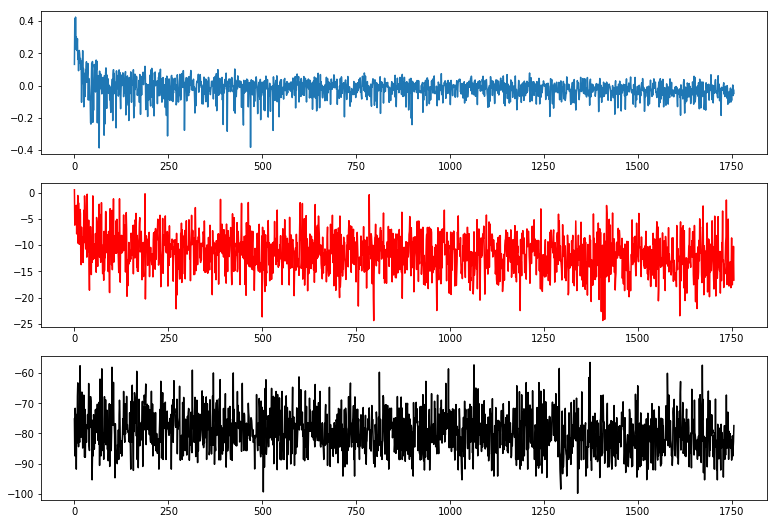

In [39]:
qmean_march, corr_march, qcorr_march = sort_vars(marchh)

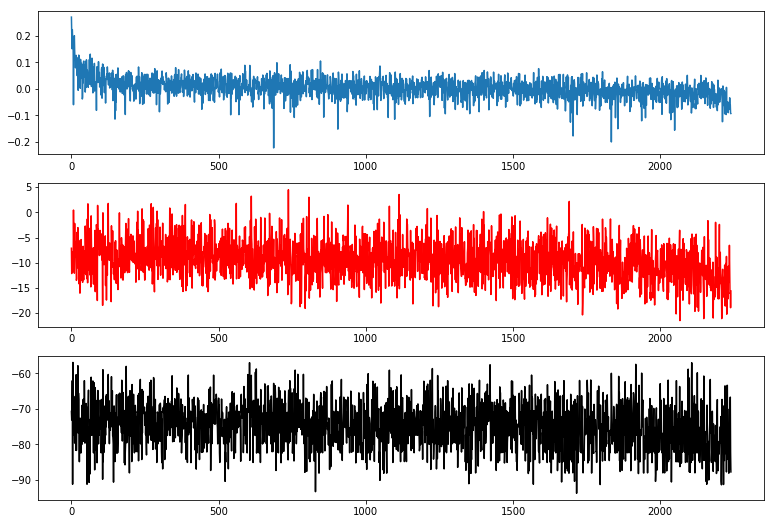

In [40]:
qmean_oct, corr_oct, qcorr_oct = sort_vars(octt)

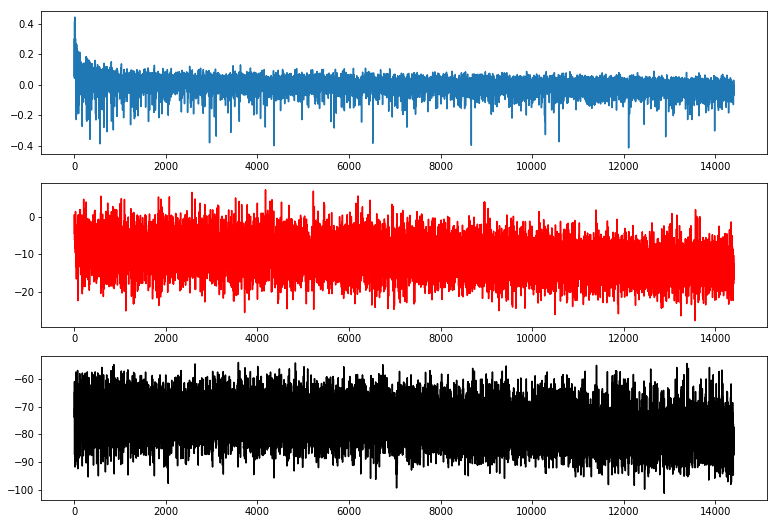

In [41]:
qmean_all, corr_all, qcorr_all = sort_vars(era_new)

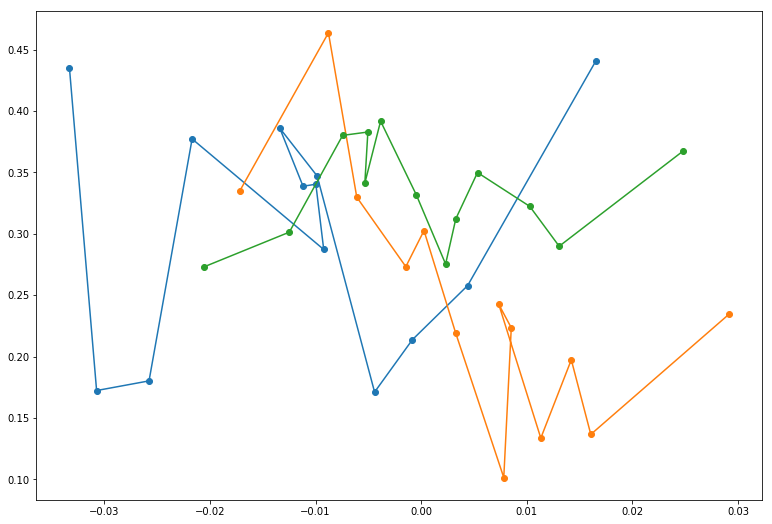

In [42]:
plt.figure(figsize=(13,9))
plt.plot(np.array(qmean_march),corr_march, '-o')
plt.plot(np.array(qmean_oct),corr_oct, '-o')
plt.plot(np.array(qmean_all),corr_all, '-o')

In [52]:
def sort_vars(dic):
    q925e = np.array(dic['q_col_sum'])
    q925s = np.array(dic['q_col_sum_s'])
    
    udic = get_col(dic['u_col'])
    vdic = get_col(dic['v_col'])
    qdic = get_col(dic['q_col'])
    qdics = get_col(dic['q_col_s'])
    
    ushear = (np.array(udic['high'])-np.array(udic['low']))
    vshear = (np.array(vdic['high'])-np.array(vdic['low']))
    shearss = u_met.u_v_to_ws_wd(ushear, vshear)
    shears = shearss[0] # np.array(dic['u650']) - np.array(dic['u925']) #shearss[0]
    
    
    q925 = (q925s-q925e)*10000+0.2 #np.array(qdics['high'])-np.array(qdic['high'])#
    sort = np.argsort(shears)
    q = q925[sort]
    shear = shears[sort]
    tmin = np.array(dic['tmin'])[sort]
    linsp = np.linspace(0,len(q)-1,20)
    
    inds = np.round(linsp).astype(int)
    #ipdb.set_trace()
    f=plt.figure(figsize=(13,9))
    ax = f.add_subplot(311)
    plt.plot(q)
    #plt.ylim(8,18)
    ax = f.add_subplot(312)
    plt.plot(shear,'r')
    ax = f.add_subplot(313)
    plt.plot(tmin,'k')
    
    plt.show()
    
    qmean = []
    corr = []
    qcorr = []
    corr_std = []
    qcorr_std = []
    print(inds)
    for start,end in enumerate(inds[2::]):  #
        print(inds[start], end)
        #ipdb.set_trace()
        qmean.append(np.median(shear[inds[start]:end]))
#         corr.append(stats.pearsonr(shear[start:end],tmin[start:end])[0])    
#         qcorr.append(stats.pearsonr(shear[start:end],q[start:end])[0])  

        ttslope, intercept, rc, p, std_err = linregress(shear[inds[start]:end],tmin[inds[start]:end])    
        ccslope, intercept, rt, p, std_err = linregress(q[inds[start]:end], shear[inds[start]:end])
        
        
        corr.append(np.median(q925[inds[start]:end])) 
        qcorr.append(np.median(tmin[inds[start]:end])) 
        
        corr_std.append(np.percentile(tmin[inds[start]:end],25))
        qcorr_std.append(np.percentile(tmin[inds[start]:end],75)) 
    return qmean, corr, qcorr, corr_std, qcorr_std

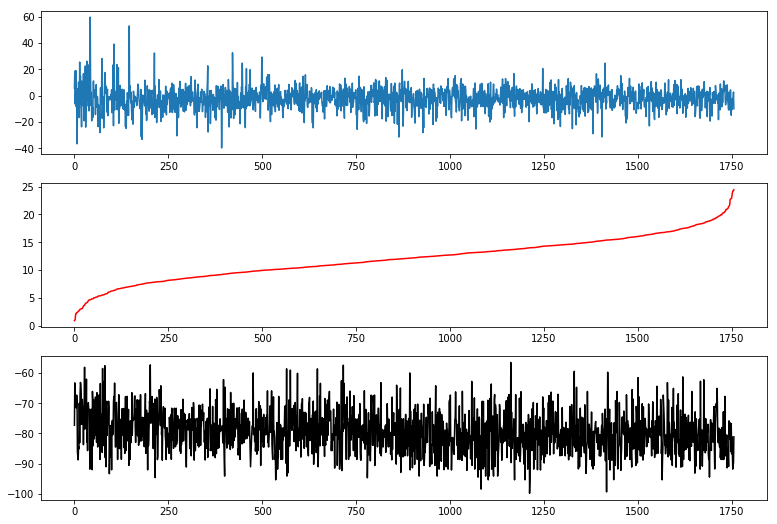

[   0   92  185  277  370  462  555  647  739  832  924 1017 1109 1201
 1294 1386 1479 1571 1664 1756]
0 185
92 277
185 370
277 462
370 555
462 647
555 739
647 832
739 924
832 1017
924 1109
1017 1201
1109 1294
1201 1386
1294 1479
1386 1571
1479 1664
1571 1756


In [53]:
qmean_march, corr_march, qcorr_march, corr_march_std, qcorr_march_std = sort_vars(marchh)

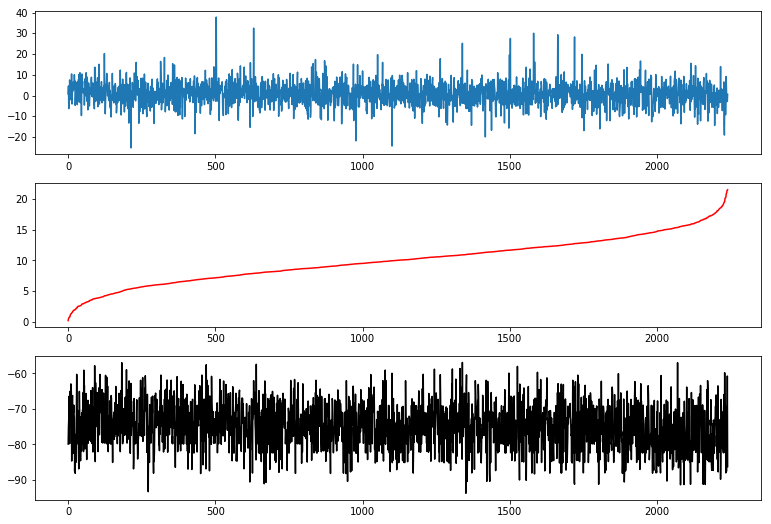

[   0  118  236  354  472  589  707  825  943 1061 1179 1297 1415 1533
 1651 1768 1886 2004 2122 2240]
0 236
118 354
236 472
354 589
472 707
589 825
707 943
825 1061
943 1179
1061 1297
1179 1415
1297 1533
1415 1651
1533 1768
1651 1886
1768 2004
1886 2122
2004 2240


In [54]:
qmean_oct, corr_oct, qcorr_oct, corr_oct_std, qcorr_oct_std = sort_vars(octt)

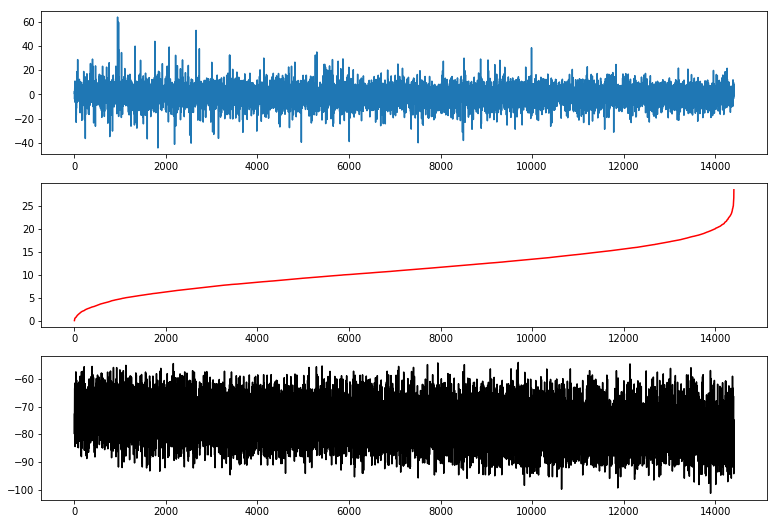

[    0   758  1517  2275  3034  3792  4551  5309  6068  6826  7585  8343
  9102  9860 10619 11377 12136 12894 13653 14411]
0 1517
758 2275
1517 3034
2275 3792
3034 4551
3792 5309
4551 6068
5309 6826
6068 7585
6826 8343
7585 9102
8343 9860
9102 10619
9860 11377
10619 12136
11377 12894
12136 13653
12894 14411


In [55]:
qmean_all, corr_all, qcorr_all, corr_all_std, qcorr_all_std = sort_vars(era_new)

In [56]:
qcorr_all_std

[-67.27999877929688,
 -68.17999267578125,
 -68.58999633789062,
 -68.989990234375,
 -69.51998901367188,
 -70.41999816894531,
 -70.52999877929688,
 -70.75999450683594,
 -70.84999084472656,
 -70.89999389648438,
 -71.489990234375,
 -72.11000061035156,
 -72.56999206542969,
 -72.72000122070312,
 -73.54998779296875,
 -73.97000122070312,
 -73.95999145507812,
 -74.54998779296875]

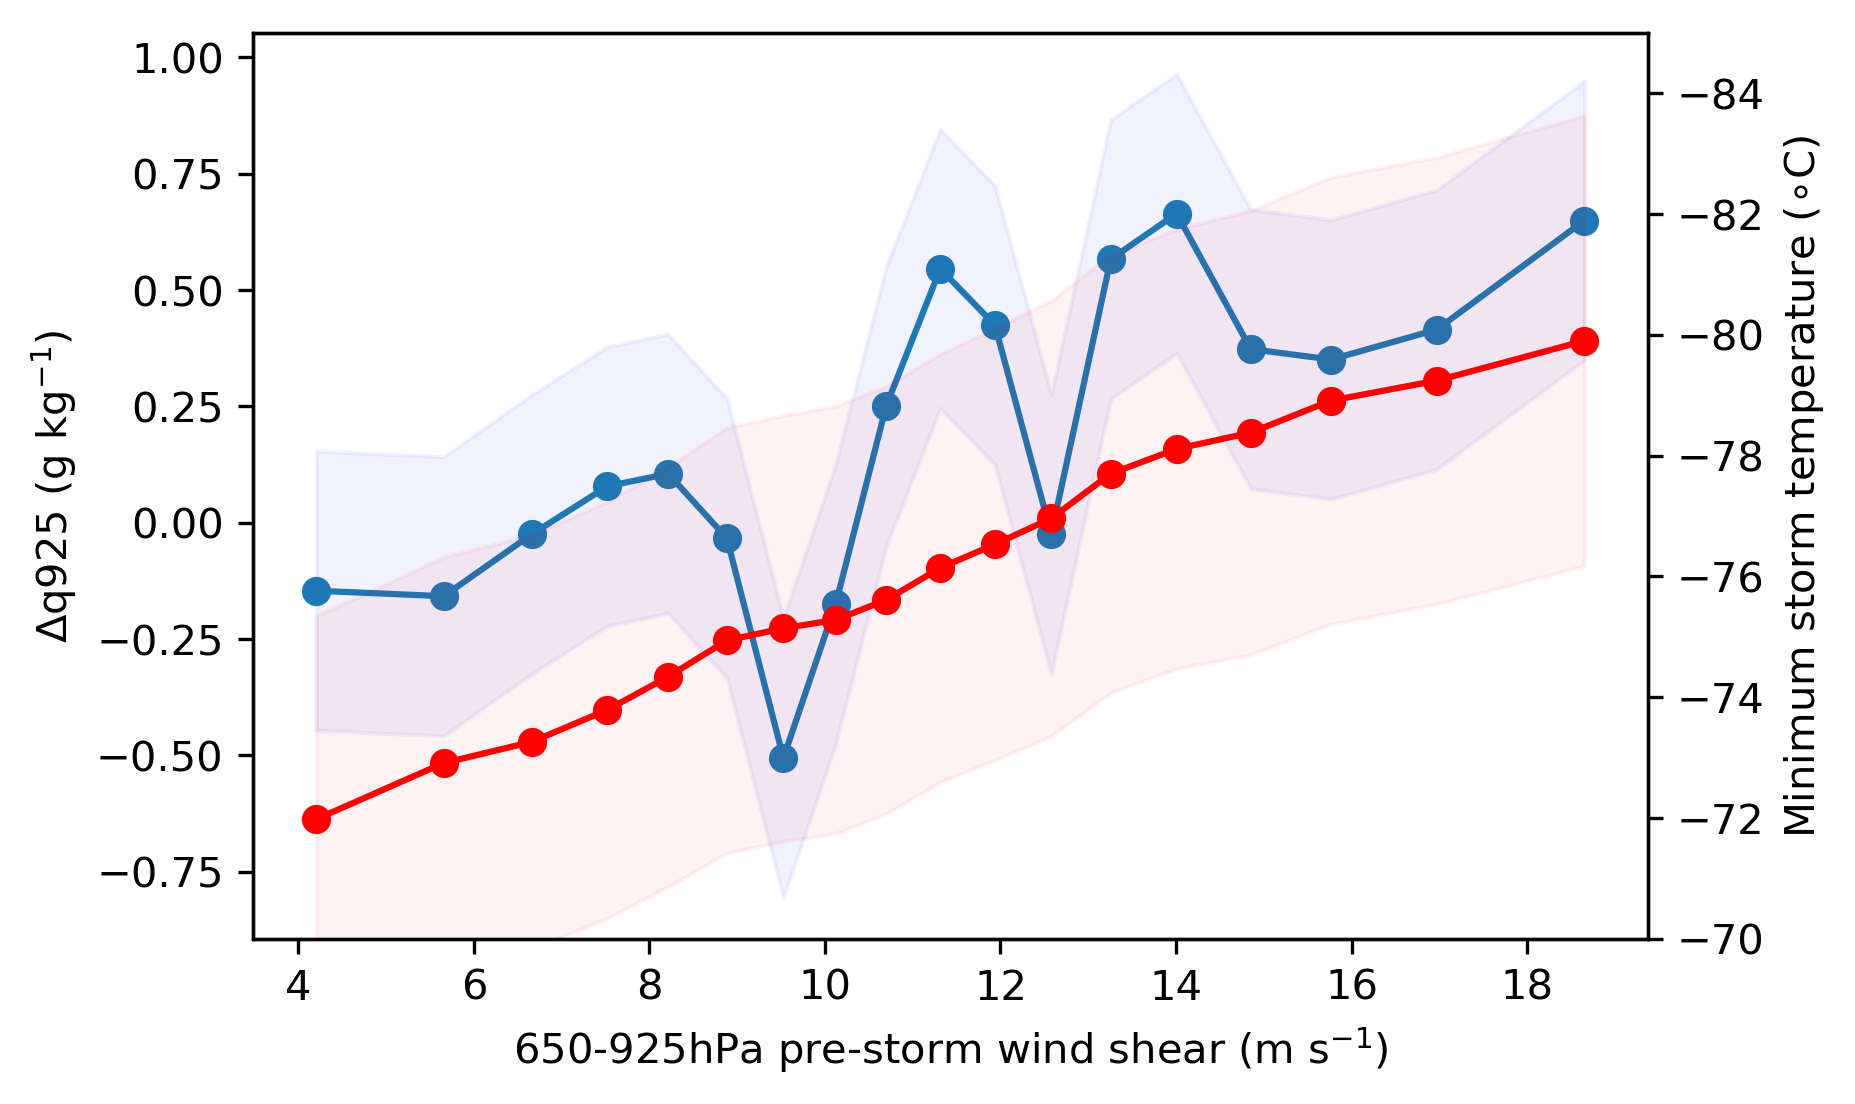

In [57]:
f=plt.figure(figsize=(6,4), dpi=300)
#plt.plot(np.array(qmean_march),corr_march, '-o')
#plt.plot(np.array(qmean_oct),corr_oct, '-o')
x = np.array(qmean_all)
corr_all = np.array(corr_all)
corr_all_std = np.array(corr_all_std)
qcorr_all = np.array(qcorr_all)
qcorr_all_std = np.array(qcorr_all_std)

ax = f.add_subplot(111)
ax.plot(x,corr_all, '-o', label='${\Delta}$q')
ax.fill_between(x,corr_all-0.3, corr_all+0.3, color='b', alpha=0.05)
ax1 = ax.twinx()
ax1.plot(x,qcorr_all, 'ro-', label='Min. storm temperature')
ax1.fill_between(x,qcorr_all-qcorr_all_std*0.05, qcorr_all+qcorr_all_std*0.05, color='r', alpha=0.05)
#ax1.errorbar(x, qcorr_all, yerr=qcorr_all_std*0.05, fmt='.k');
ax1.set_ylim(-85,-70)
ax1.set_ylim(ax1.get_ylim()[::-1])
ax.set_xlabel('650-925hPa pre-storm wind shear (m s$^{-1}$)')
ax.set_ylabel('${\Delta}$q925 (g kg$^{-1}$)')
ax1.set_ylabel('Minimum storm temperature (${\circ}$C)')

plt.savefig('/home/ck/DIR/cornkle/figs/CLOVER/deltaQ_pre-stormTime.png')

In [58]:
def sort_vars(dic):
    q925e = dic['t2']#np.array(dic['q_col_sum'])
    q925s = dic['t2_s']#np.array(dic['q_col_sum_s'])
    
    udic = get_col(dic['u_col'])
    vdic = get_col(dic['v_col'])
    qdic = get_col(dic['q_col'])
    qdics = get_col(dic['q_col_s'])
    
    ushear = (np.array(udic['high'])-np.array(udic['low']))
    vshear = (np.array(vdic['high'])-np.array(vdic['low']))
    shearss = u_met.u_v_to_ws_wd(ushear, vshear)
    shears = shearss[0] # np.array(dic['u650']) - np.array(dic['u925']) #shearss[0]
    
    
    q925 = (q925e-q925s)#*10000+0.2 #np.array(qdics['high'])-np.array(qdic['high'])#
    sort = np.argsort(shears)
    q = q925[sort]
    shear = shears[sort]
    tmin = np.array(dic['tmin'])[sort]
    linsp = np.linspace(0,len(q)-1,20)
    
    inds = np.round(linsp).astype(int)
    #ipdb.set_trace()
    f=plt.figure(figsize=(13,9))
    ax = f.add_subplot(311)
    plt.plot(q)
    #plt.ylim(8,18)
    ax = f.add_subplot(312)
    plt.plot(shear,'r')
    ax = f.add_subplot(313)
    plt.plot(tmin,'k')
    
    plt.show()
    
    qmean = []
    corr = []
    qcorr = []
    corr_std = []
    qcorr_std = []
    print(inds)
    for start,end in enumerate(inds[2::]):  #
        print(inds[start], end)
        #ipdb.set_trace()
        qmean.append(np.median(shear[inds[start]:end]))
#         corr.append(stats.pearsonr(shear[start:end],tmin[start:end])[0])    
#         qcorr.append(stats.pearsonr(shear[start:end],q[start:end])[0])  

        ttslope, intercept, rc, p, std_err = linregress(shear[inds[start]:end],tmin[inds[start]:end])    
        ccslope, intercept, rt, p, std_err = linregress(q[inds[start]:end], shear[inds[start]:end])
        
        
        corr.append(np.median(q925[inds[start]:end])) 
        qcorr.append(np.median(tmin[inds[start]:end])) 
        
        corr_std.append(np.percentile(tmin[inds[start]:end],25))
        qcorr_std.append(np.percentile(tmin[inds[start]:end],75)) 
    return qmean, corr, qcorr, corr_std, qcorr_std

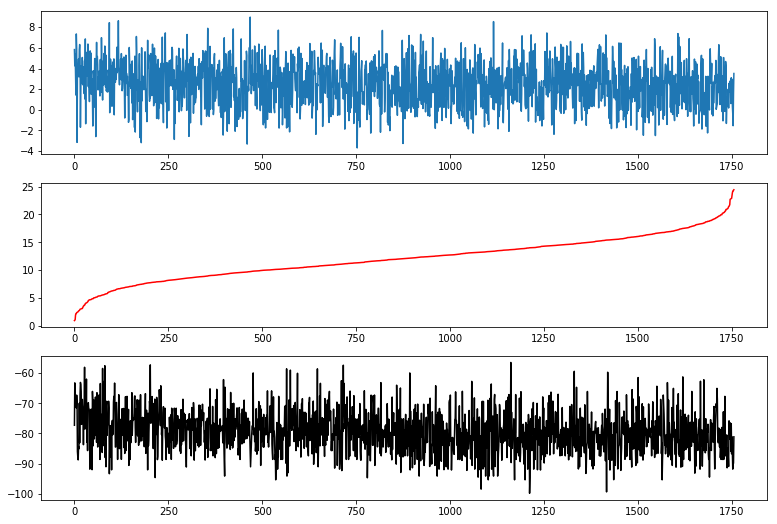

[   0   92  185  277  370  462  555  647  739  832  924 1017 1109 1201
 1294 1386 1479 1571 1664 1756]
0 185
92 277
185 370
277 462
370 555
462 647
555 739
647 832
739 924
832 1017
924 1109
1017 1201
1109 1294
1201 1386
1294 1479
1386 1571
1479 1664
1571 1756


In [59]:
qmean_march, corr_march, qcorr_march, corr_march_std, qcorr_march_std = sort_vars(marchh)

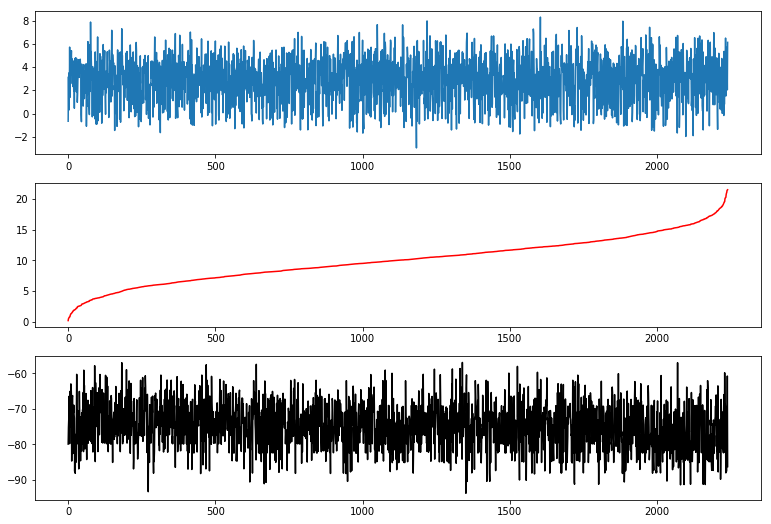

[   0  118  236  354  472  589  707  825  943 1061 1179 1297 1415 1533
 1651 1768 1886 2004 2122 2240]
0 236
118 354
236 472
354 589
472 707
589 825
707 943
825 1061
943 1179
1061 1297
1179 1415
1297 1533
1415 1651
1533 1768
1651 1886
1768 2004
1886 2122
2004 2240


In [60]:
qmean_oct, corr_oct, qcorr_oct, corr_oct_std, qcorr_oct_std = sort_vars(octt)

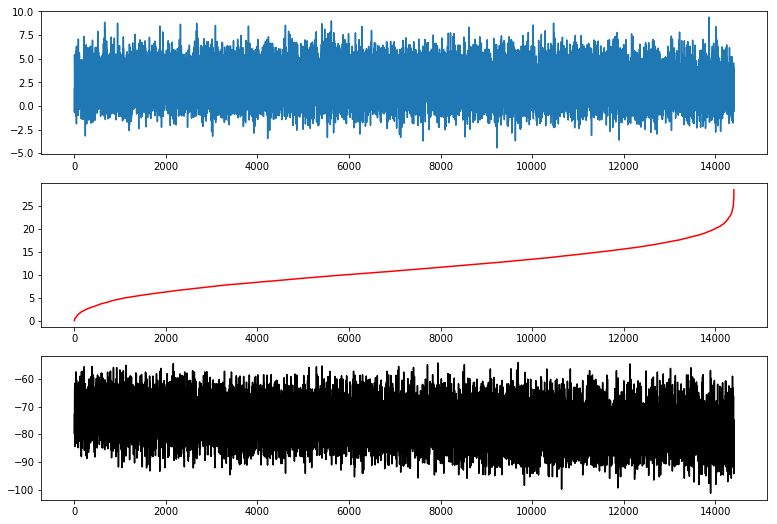

[    0   758  1517  2275  3034  3792  4551  5309  6068  6826  7585  8343
  9102  9860 10619 11377 12136 12894 13653 14411]
0 1517
758 2275
1517 3034
2275 3792
3034 4551
3792 5309
4551 6068
5309 6826
6068 7585
6826 8343
7585 9102
8343 9860
9102 10619
9860 11377
10619 12136
11377 12894
12136 13653
12894 14411


In [61]:
qmean_all, corr_all, qcorr_all, corr_all_std, qcorr_all_std = sort_vars(era_new)

Text(0, 0.5, 'Minimum storm temperature (${\\circ}$C)')

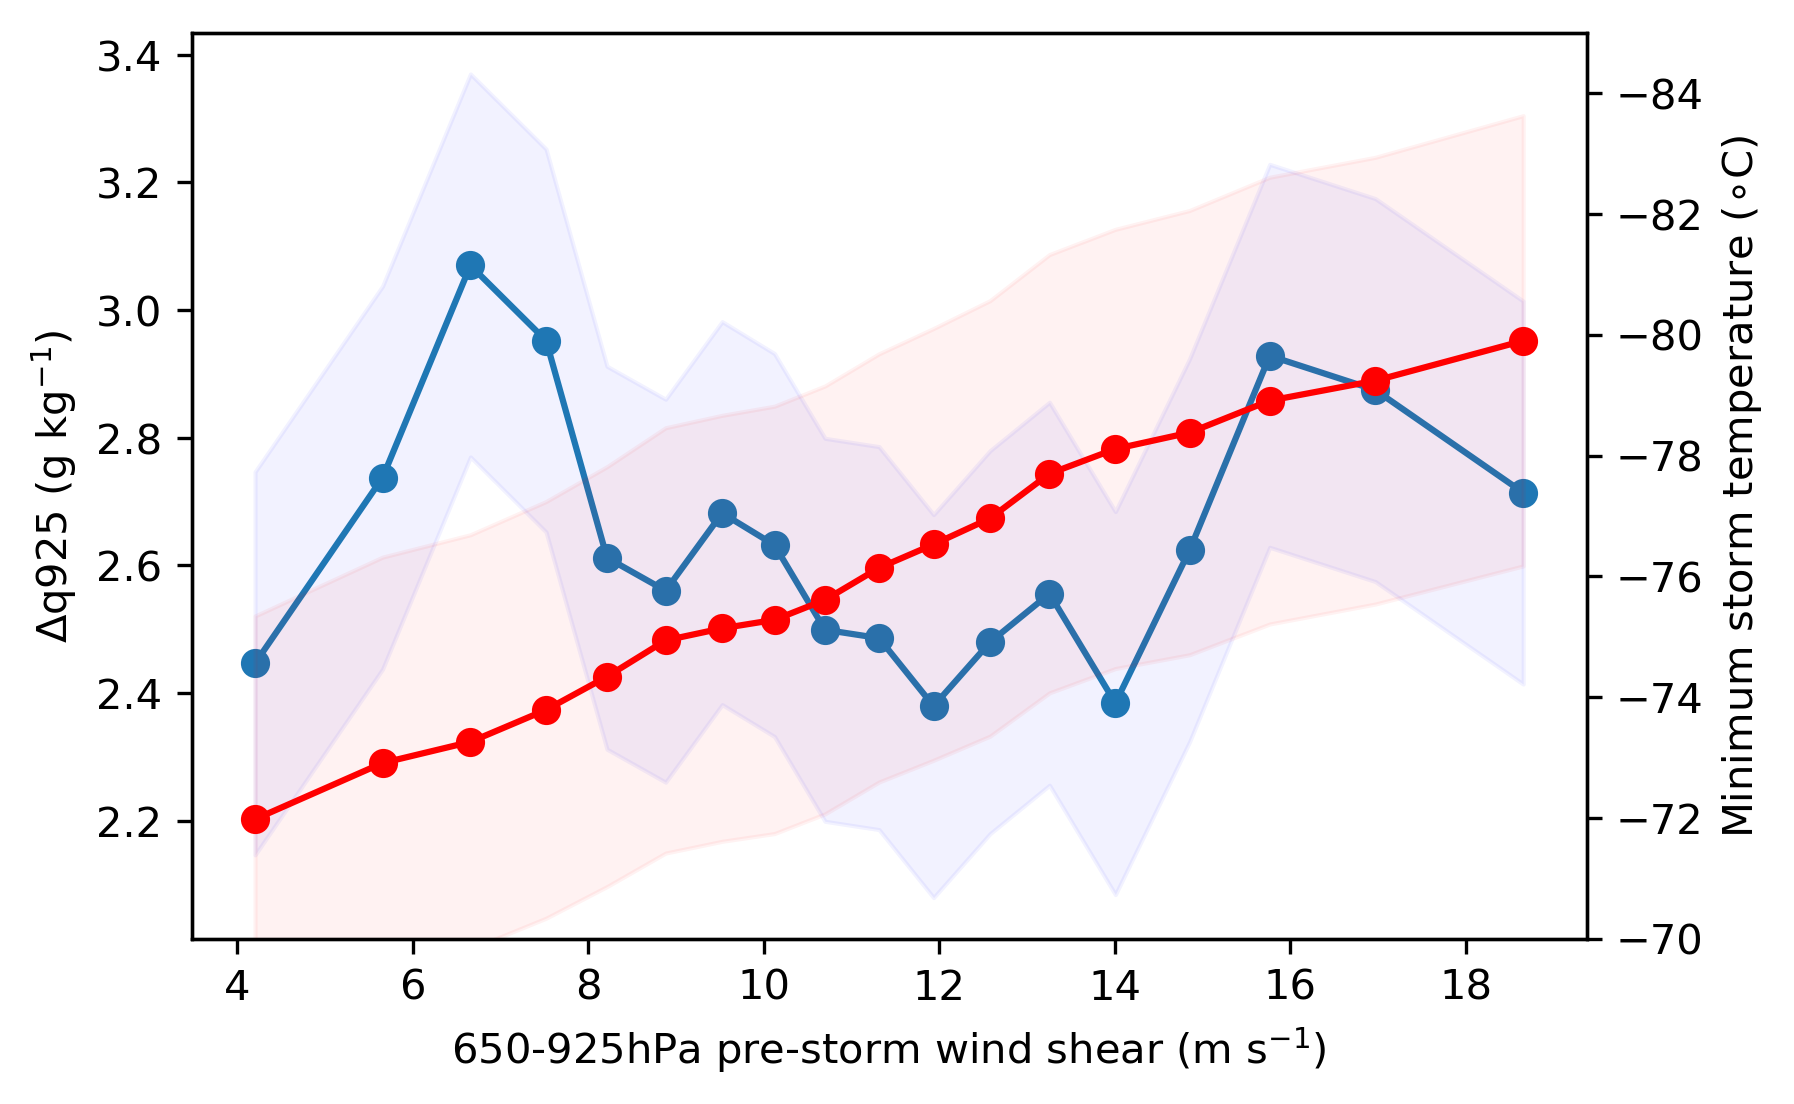

In [62]:
f=plt.figure(figsize=(6,4), dpi=300)
#plt.plot(np.array(qmean_march),corr_march, '-o')
#plt.plot(np.array(qmean_oct),corr_oct, '-o')
x = np.array(qmean_all)
corr_all = np.array(corr_all)
corr_all_std = np.array(corr_all_std)
qcorr_all = np.array(qcorr_all)
qcorr_all_std = np.array(qcorr_all_std)

ax = f.add_subplot(111)
ax.plot(x,corr_all, '-o', label='${\Delta}$q')
ax.fill_between(x,corr_all-0.3, corr_all+0.3, color='b', alpha=0.05)
ax1 = ax.twinx()
ax1.plot(x,qcorr_all, 'ro-', label='Min. storm temperature')
ax1.fill_between(x,qcorr_all-qcorr_all_std*0.05, qcorr_all+qcorr_all_std*0.05, color='r', alpha=0.05)
#ax1.errorbar(x, qcorr_all, yerr=qcorr_all_std*0.05, fmt='.k');
ax1.set_ylim(-85,-70)
ax1.set_ylim(ax1.get_ylim()[::-1])
ax.set_xlabel('650-925hPa pre-storm wind shear (m s$^{-1}$)')
ax.set_ylabel('${\Delta}$q925 (g kg$^{-1}$)')
ax1.set_ylabel('Minimum storm temperature (${\circ}$C)')

#plt.savefig('/home/ck/DIR/cornkle/figs/CLOVER/deltaQ_pre-stormTime.png')

-0.0011895272212990395 0.8864557231848981


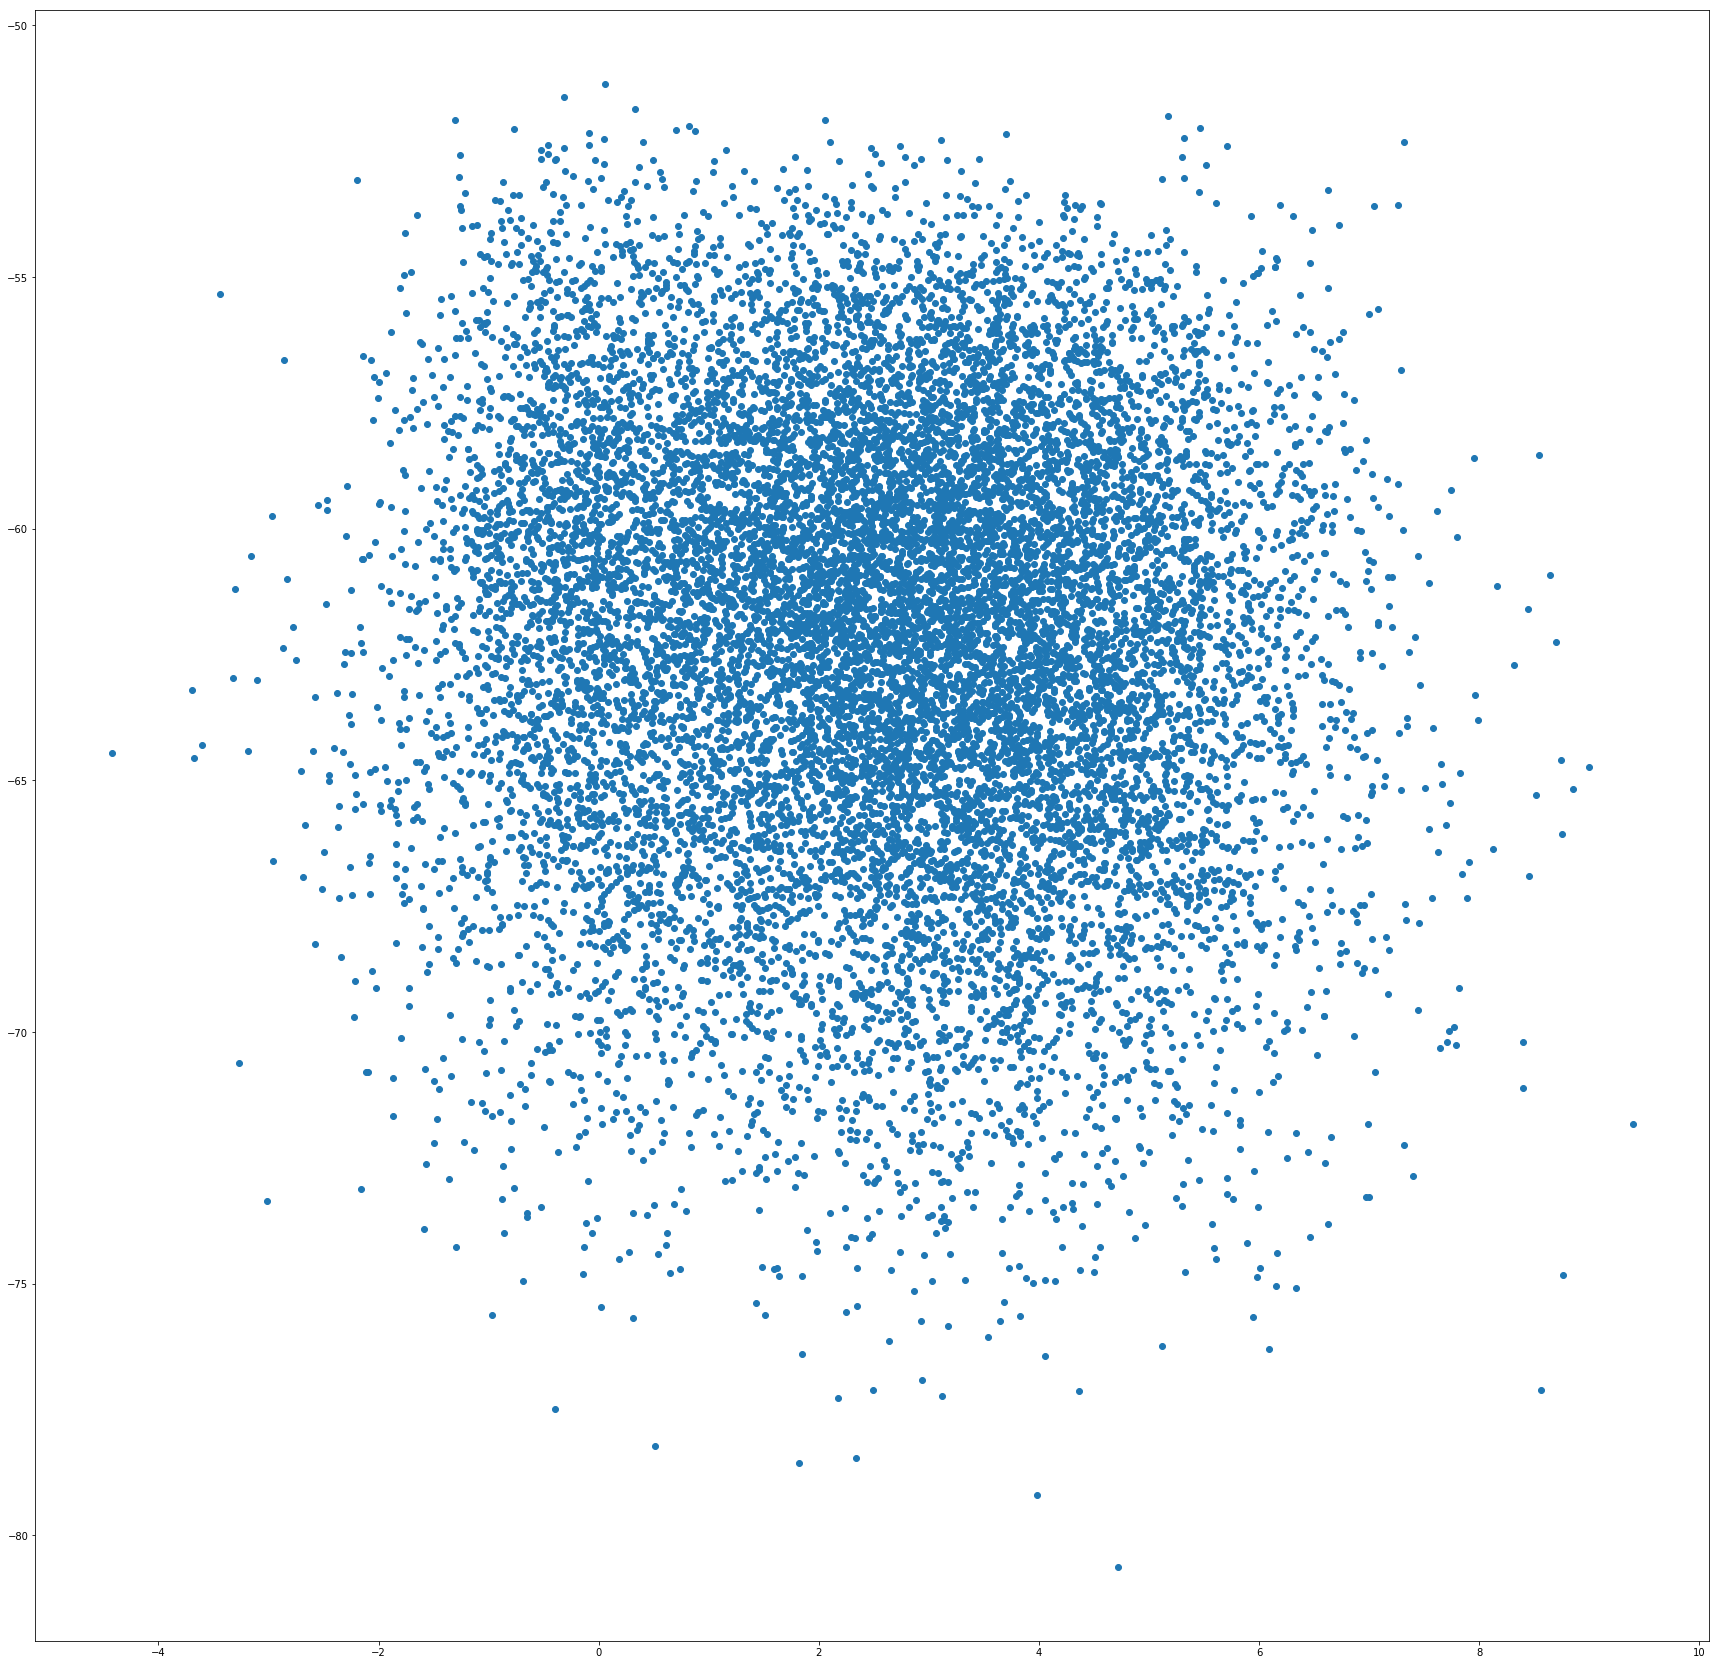

In [86]:
f = plt.figure()
ax = f.add_subplot(111)
x = (era_new['t2']-era_new['t2_s'])
y = (era_new['tmean'])
ax.scatter(x,y)
#slope, intercept, r_value, p_value, std_err = stats.linregress(era_new['t2']-era_new['t2_s'],era_new['divMoist']*1000)
#ax.plot(np.linspace(x.min(),x.max(),6), intercept + np.linspace(x.min(),x.max(),6)*slope, '--', color='r')
print(r_value, p_value)
#ax.set_ylim(-1,1)

(array([  11.,  150., 1214., 2267., 3179., 3793., 2623.,  994.,  163.,
          18.]),
 array([-4.42492676, -3.04277344, -1.66062012, -0.2784668 ,  1.10368652,
         2.48583984,  3.86799316,  5.25014648,  6.6322998 ,  8.01445313,
         9.39660645]),
 <a list of 10 Patch objects>)

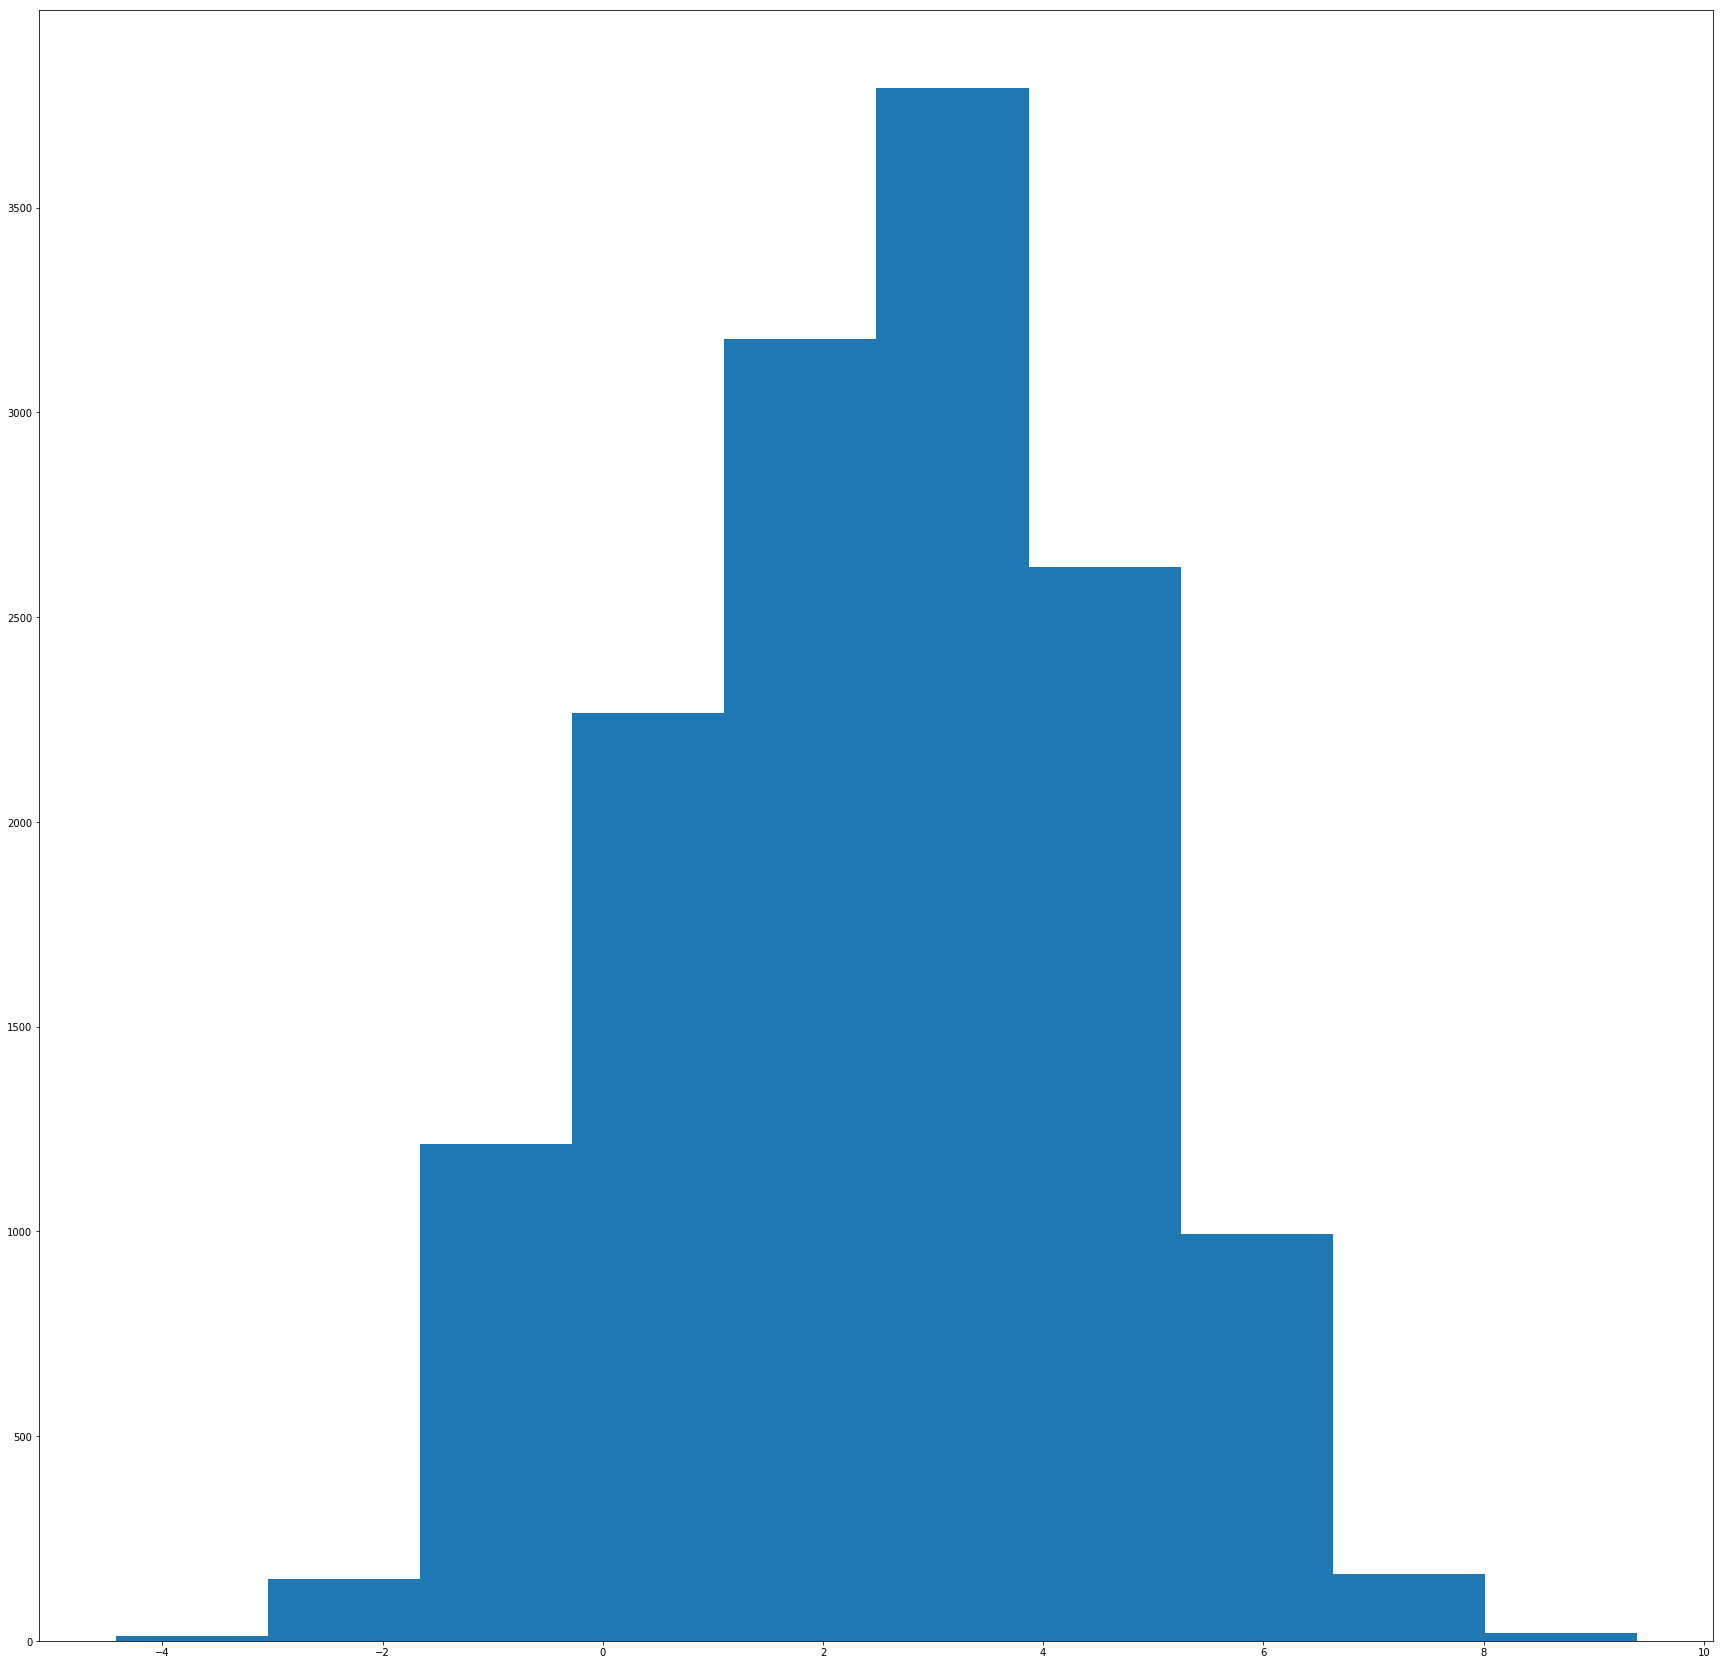

In [81]:
f = plt.figure()
ax = f.add_subplot(111)
x = (era_new['t2']-era_new['t2_s'])
y = (era_new['d925'])*10000
ax.hist(x)